## Idea:
How accurately can we measure the position from the autocorrelation?
A simple idea would be to do the full autocorrelation, then fit a Gaussian to the peak at the binary separation.
## Result:
It gave accuracies up to 1e-4 pixels, and shows the signal clearly if it's that size. With 1e-5 pixels, there is a periodogram peak at the right place, but it's not significant (from 100 images, maybe with 1000). (Noise is 100ppm)

## Effects of WFE:
With no WFE, noise stddev is 4.1ppm.\
With 1nm RMS WFE, noise stddev is 5.7ppm.\
With 5nm RMS WFE, noise stddev is 50 ppm.\
With 10nm RMS WFE, noise stddev is 185 ppm.\
With 20nm RMS WFE, noise stddev is 721 ppm. \
With 50nm RMS WFE, noise stddev is 4340 ppm. \
With 100nm RMS WFE, noise stddev is 14386 ppm. 

The signal seems to follow the defocus term, but that might just be luck. \
Going from 0.5wav to -0.35wav is 0.06pix change in sep.\
Going from 0.025wav to -0.015wav is 0.0002 pix change in sep. (i.e. not linear). \
Also putting all of the WFE into one term leads to much worse accuracy than spreading it out.

## Effects of WFE on Larkin Transformed data with Autocorrelation:
With no WFE, noise stddev is 5685 ppm.\
With 1nm RMS WFE, noise stddev is 6643 ppm.\
With 5nm RMS WFE, noise stddev is 6441 ppm.\
With 10nm RMS WFE, noise stddev is 7042 ppm.\
With 20nm RMS WFE, noise stddev is 9335 ppm. \
With 50nm RMS WFE, noise stddev is 18413 ppm. \
With 100nm RMS WFE, noise stddev is 47852 ppm. 

## Effects of WFE on Larkin Transformed data **squared** with Autocorrelation:
With no WFE, noise stddev is 214 ppm.\
With 1nm RMS WFE, noise stddev is 249 ppm.\
With 5nm RMS WFE, noise stddev is 665 ppm.\
With 10nm RMS WFE, noise stddev is 1297 ppm.\
With 20nm RMS WFE, noise stddev is 2665 ppm. \
With 50nm RMS WFE, noise stddev is 7447 ppm. \
With 100nm RMS WFE, noise stddev is 18163 ppm. 

## Effects of individual WFE terms on Autocorrelation:
Tried using same WFE as the 100nm RMS WFE sim above, but using one term only.\
With defocus only (38nm RMS WFE), noise stddev is 2305ppm. First few frames contribute almost all of the scatter, 900ppm otherwise. \
With astigmatism only (58nm RMS WFE), noise stddev is 12025ppm. So it really dominates the final error budget. \
With coma only (42nm RMS WFE), noise stddev is 3767ppm. 

Why is astigmatism so much worse than coma though? Seems like coma is more asymmetric and should be worse...

## Effects of photon noise on Autocorrelation:
1e2 photons peak: 23417 ppm.\
1e3 photons peak: 7555 ppm.\
1e4 photons peak: 2222 ppm.\
1e5 photons peak: 846 ppm.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/cheetham/Dropbox/code/toliman/Toliman/lib/')
import photometry
sys.path.append('/Users/cheetham/Dropbox/code/toliman/Toliman/COIN/signal_extraction/')
from modelling_functions import autocorrelate,larkin_autocor_model

In [2]:
# What's the position of the blob
from astropy.modeling import models, fitting
def calc_sep(im2,plot=False,plot_resids=False,larkin_transform=False):
    rough_pa = 0
    rough_sep =44.93
    rough_pos = np.round([rough_sep*np.sin(rough_pa),rough_sep*np.cos(rough_pa)]).astype(int)
    calc_pos = [rough_sep*np.sin(rough_pa),rough_sep*np.cos(rough_pa)]
    
    cutout_sz = 3 # was 3
    cutout = np.copy(im2[im2.shape[0]//2+rough_pos[0]-cutout_sz:im2.shape[0]//2+rough_pos[0]+cutout_sz,
                 im2.shape[1]//2+rough_pos[1]-cutout_sz:im2.shape[1]//2+rough_pos[1]+cutout_sz])

    cutout /= np.max(cutout)
    if plot:
        plt.imshow(cutout)

    x,y = np.indices(cutout.shape)
    x = x + rough_pos[0] - cutout_sz
    y = y + rough_pos[1] - cutout_sz
    # Fit a Gaussian
    fit = fitting.LevMarLSQFitter()
    if larkin_transform:
        gauss = larkin_autocor_model(amplitude=cutout.max(),x_mean_0=calc_pos[0],y_mean_0=calc_pos[1],width=1.83)
        cutout_model = gauss
    else:
        gauss = models.Gaussian2D(amplitude = cutout.max(),x_stddev=1.36,y_stddev=1.36,
                                  x_mean=calc_pos[0],y_mean=calc_pos[1])
        bckgd = models.Planar2D(slope_x = -0.00564816,slope_y=-0.02378304,intercept=1.01)
        gauss.fixed['theta']=True
        cutout_model = gauss + bckgd

    # fit the data with the fitter
    fitted_model = fit(cutout_model,x,y,cutout,maxiter=100000);
    
    if plot_resids:
        test = fitted_model(x,y)
        plt.figure(figsize=(12,4))
        plt.clf()
        plt.subplot(131)
        plt.imshow(cutout,origin='lowerleft',vmin=0.7,vmax=1);plt.colorbar()
        plt.subplot(132)
        plt.imshow(test,origin='lowerleft',vmin=0.7,vmax=1);plt.colorbar()
        plt.subplot(133)
        plt.imshow(cutout-test,origin='lowerleft',vmin=-0.05,vmax=0.05);plt.colorbar()
    return fitted_model

In [3]:
# sim_name = '../sims/100nm_wfe_with_jitter/'
# sim_name = '../sims/defocus_and_jitter/'
# sim_name = '../sims/astig_and_jitter/'
# sim_name = '../sims/jitter_only/'
sim_name = '../sims/toliman_100k_photons/'
# sim_name = '../sims/linear_jitter_horiz/'
# sim_name = '../no_rotation_1e3signal/'
# sim_name = '../sims/toliman_photon_noise/'
# sim_name = '../sims/round_pupil_photon_noise/'
model_PSF = np.load('../signal_extraction/model_psf.npy')

# sim_name = '../sims/airydisk/'
# model_PSF = np.load(sim_name+'model_psf.npy')

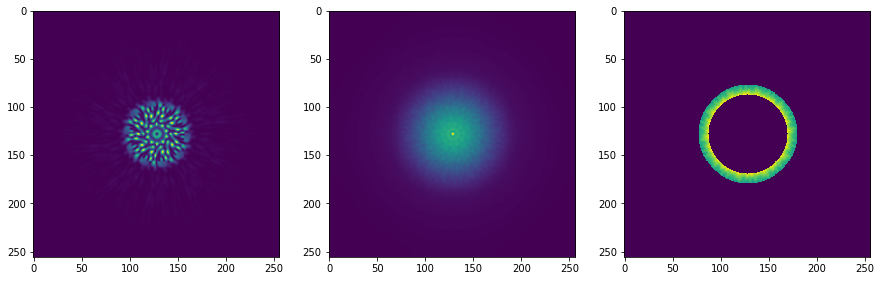

In [4]:
# Show it
im = np.load(sim_name+'images/{}.npy'.format(0))
im = model_PSF
im = im/im.max()
autocor = autocorrelate(im,larkin_transform=False,model_PSF=model_PSF)

plt.figure(figsize=(15,9))
plt.subplot(131)
plt.imshow(im)


plt.subplot(132)
plt.imshow(autocor)

# We know the rough sep
rough_sep = 46 # pix
x,y = np.indices(autocor.shape)
R = np.hypot(x-autocor.shape[0]//2,y-autocor.shape[1]//2)
mask = 0*R
mask[np.abs(R-rough_sep)<5] = 1
plt.subplot(133)
plt.imshow(mask*(autocor))

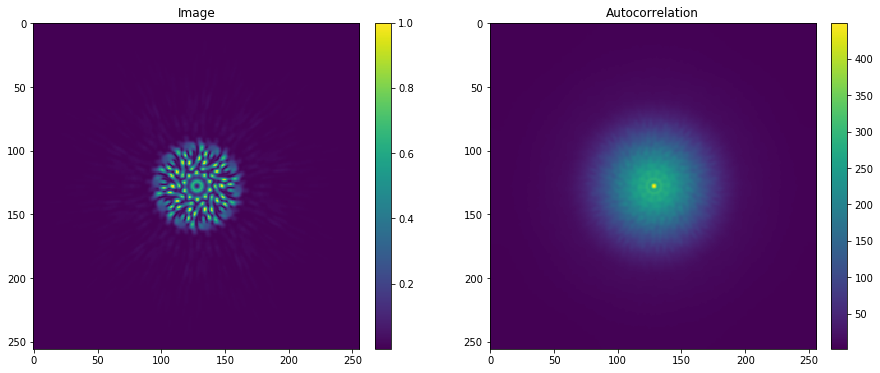

In [5]:
# Plot for the report
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.imshow(im);plt.title('Image');plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(autocor);plt.title('Autocorrelation');plt.colorbar(fraction=0.046, pad=0.04)
# import matplotlib as mpl
# circ = mpl.patches.Circle([autocor.shape[0]//2,autocor.shape[1]//2],65,fill=None)
# plt.gca().add_artist(circ)
# plt.savefig('/Users/cheetham/Google Drive/Backup/astro_things/reports/toliman_work/autocorrelation.pdf',dpi=500)

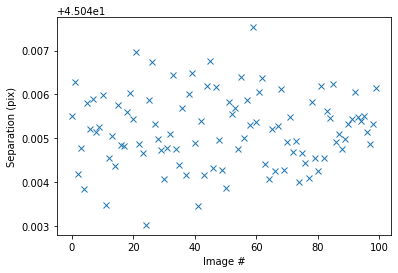

In [6]:
# Loop over some images
from IPython.display import clear_output
xs = []
ys = []
seps = []
larkin_transform=False
for ix in range(100):
    im = np.load(sim_name+"images/{}.npy".format(ix))
    
    autocor_image = autocorrelate(im,larkin_transform=larkin_transform,model_PSF=model_PSF,pad=True)
    
    model = calc_sep(autocor_image,larkin_transform=larkin_transform,plot_resids=False)
    
    xs.append(model.x_mean_0[0])
    ys.append(model.y_mean_0[0])
    seps.append(np.sqrt(model.x_mean_0[0]**2+model.y_mean_0[0]**2))
    
    clear_output(wait=True)
    plt.plot(ys,'x')
    plt.xlabel('Image #')
    plt.ylabel('Separation (pix)')
    plt.show()

xs = np.array(xs)
ys = np.array(ys)
seps = np.array(seps)

<Figure size 432x288 with 0 Axes>

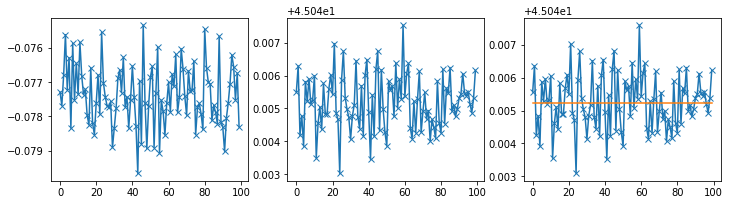

In [7]:
signal = np.loadtxt(sim_name+'signal.csv',skiprows=1,delimiter=',')
plt.clf()
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.plot(xs,'-x')

plt.subplot(132)
plt.plot(ys,'-x')

plt.subplot(133)
plt.plot(seps,'-x')
plt.plot(signal[:,1]+np.median(seps))
# plt.plot(signal[:,1])

(-0.005619577643320731, 0.12324475430954225)

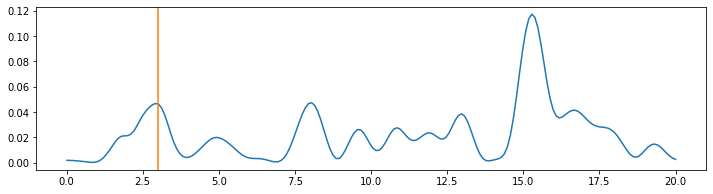

In [8]:
# Plot frequencies
from astropy.timeseries import LombScargle
frequency = np.linspace(0.01, 20., len(xs)*2)
t = np.arange(xs.shape[0])/xs.shape[0]
plt.figure(figsize=(12,3))
power = LombScargle(t, seps).power(frequency)
plt.plot(frequency,power)
yl = plt.ylim()
plt.plot([3.,3.],yl,'-')
plt.ylim(yl)

In [9]:
print('X,Y scatter in ppm:',np.std(xs)*1e6,np.std(ys)*1e6)
print('Sep accuracy in ppm:',np.std(seps-signal[0:len(seps),1])*1e6)
print(sim_name)

X,Y scatter in ppm: 885.9624769448266 825.7179653603669
Sep accuracy in ppm: 826.0012446185686
../sims/toliman_100k_photons/


In [10]:
# What's the offset from the true value? Seems to be 0.125 pixel for the sim with jitter only.
print(np.median(seps))
print(np.median(seps)-44.91985222)

45.04524638799833
0.12539416799832992
